# Projet 5 : Segmentez les comportements de clients
# <u>C. Modèle de classification automatique des clients</u> <br/>

# Le contexte

Notre employeur Datazon souhaite mieux comprendre le comportements de ses clients afin de faire de meilleures ventes et augmenter son chiffre d'affaire.

Notre **objectif** est de mieux comprendre les clients afin de les classer en catégories et de déterminer automatiquement la catégorie d'un client dès son premier achat.

Ce notebook traite de la partie classification automatique des clients pour trouver leur type de catégorie. Pour celà nous allons tester et évaluer différents modéles de classification.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import  manifold, cluster
from IPython.display import display

from sklearn import model_selection, metrics
from sklearn.svm import SVC
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import confusion_matrix,roc_curve, auc
import itertools
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import label_binarize


%matplotlib inline

# 1. Importation des données

On importe notre base clients contenant la segmentation trouvée dans la partie précédente.
Pour rappel, nous avions découpé nos données en jeu de d'apprentissage et jeu de test. Le jeu d'apprentissage a été utilisé pour trouver les clusters.

In [2]:
customers_data= pd.read_csv('customers_data.csv')

In [3]:
customers_data.head()

,CustomerID,NbOrders,TotalSpent,AverageSpent,MinSpent,MaxSpent,TotalQuantity,NbCanceled,NbDiscount,NbPromo,isUK,LastPurchase,Cluster
0,12346.0,2,0.00,0.00,-77183.60,77183.60,0,1,0,0,1,325,0
1,12347.0,4,2579.44,644.86,224.82,1294.32,1460,0,0,0,0,2,4
2,12348.0,2,457.44,228.72,187.44,270.00,816,0,0,0,0,75,3
3,12349.0,1,1457.55,1457.55,1457.55,1457.55,630,0,0,0,0,18,4
4,12350.0,1,294.40,294.40,294.40,294.40,196,0,0,0,0,310,2


Nos données contiennent bien le numéro de cluster attribué à chaque client.

# 2. Tests des modèles de classification

Dans cette section nous avons évaluer différents algorithmes de classification capable de determiner la catégorie (cluster) d'un client.
Nous allons comparer la catégorie prédite par rapport à celle determinée avec KMeans pour vérifier la précision du modèle.

## 2.1 Préparation des données

Notre target variable et le numéro de cluster.
On utilise les autres features pour notre apprentissage (en supprimant bien-sûr l'identifiant client et l'information sur le cluster).

In [4]:
Y = customers_data['Cluster']
X = customers_data.drop(['CustomerID','Cluster'], axis=1)

In [5]:
X.head()

,NbOrders,TotalSpent,AverageSpent,MinSpent,MaxSpent,TotalQuantity,NbCanceled,NbDiscount,NbPromo,isUK,LastPurchase
0,2,0.00,0.00,-77183.60,77183.60,0,1,0,0,1,325
1,4,2579.44,644.86,224.82,1294.32,1460,0,0,0,0,2
2,2,457.44,228.72,187.44,270.00,816,0,0,0,0,75
3,1,1457.55,1457.55,1457.55,1457.55,630,0,0,0,0,18
4,1,294.40,294.40,294.40,294.40,196,0,0,0,0,310


On découpe les données en jeu d'entrainement et de test pour notre apprentissage (70% / 30%).
Le jeu de test permettra de mesurer la qualité de la prédiction.

In [6]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X,Y,test_size = 0.3,random_state = 0)

Avant de tester nos modèles, nous faisons un traitement sur les données pour les valoriser selon les quantiles comme nous l'avons fait pour le clustering.

In [7]:
# On attribue un score en fonction de quantile d'appartenance de la donnée
def getScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

# Calcul score pour les données dont la valorisation est plus importance si la valeur est faible
# Ex : LastPurchase. Plus la valeur est petite, plus l'achat est récent donc à une valorisation importante pour nous.
def getRScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
# Transforme les données en score de quantile et retourne une matrice
def createQuantileMatrix(X) :
    quantiles = X.quantile(q=[0.25,0.5,0.75])
    quantiles = quantiles.to_dict()
    X_std=X.copy()
    for column in X:
        if (column == 'LastPurchase') :
            X_std[column] = X[column].apply(getRScore, args=(column,quantiles,))
        else :
            X_std[column] = X[column].apply(getScore, args=(column,quantiles,))
    return X_std

On valorise les données d'entrainement et de test.

In [8]:
x_train = createQuantileMatrix(x_train)
x_test = createQuantileMatrix(x_test)

## 2.2 Evaluation des modèles

Pour évaluer la qualité des modèles de classification, on a écrit quelque méthodes génériques qui seront utilisées par la suite.

In [9]:
'''
Méthode générique pour faire une recherche sur grille et évaluer le modèle de classification.
Affiche les meilleurs paramètres et la précision du modèle.
'''
def evaluateClassifier(classifier, parameters, x_train, y_train, x_test, y_test) :
    Kfold = 5
    gs_classifier = GridSearchCV(estimator = classifier, param_grid = parameters, cv = Kfold)
    fit = gs_classifier.fit(x_train, y_train)
    print("Best params :", gs_classifier.best_params_)
    y_pred = gs_classifier.predict(x_test)
    
    print("Classification accuracy: {:.2f} % ".format(100*metrics.accuracy_score(y_test, y_pred)))
    return gs_classifier, y_pred

In [10]:
'''
Affichage de la matrice de confusion
'''
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def displayConfusionMatrix(y_test, y_pred,n_classes) :
    class_names = [i for i in range(n_classes)]
    cnf_matrix = confusion_matrix(y_test, y_pred) 
    np.set_printoptions(precision=2)
    plt.figure(figsize = (5,5))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

Pour tous les modèles testés, nous allons faire la recherche sur grille pour trouver les meilleurs hyperparamètres et la validation croisée pour éviter le surapprentissage.

## 2.3 SVM Linéaire

On commence par tester le modèle de machine à vecteurs de support.

In [11]:
svc = svm.LinearSVC()
parameters = [{'C':np.logspace(-3,3,10)}]
svc_grid, y_pred = evaluateClassifier(svc,parameters, x_train, y_train, x_test, y_test  )

Best params : {'C': 2.154434690031882}
Classification accuracy: 98.10 % 


Confusion matrix, without normalization


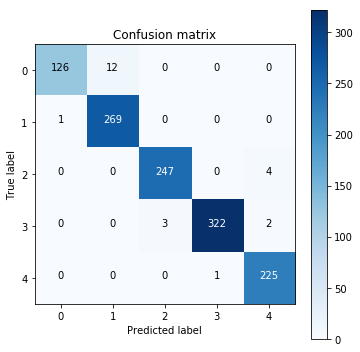

In [12]:
displayConfusionMatrix(y_test, y_pred,5)

=> Le résultat est plutôt bon.

## 2.4 Logistic Regression

Voyons maintenant la régression logistique.

In [13]:
lr = linear_model.LogisticRegression()
parameters = [{'penalty': ['l2', 'l1'],'C':np.logspace(-2,2,20)}]
lr_grid, y_pred = evaluateClassifier(lr,parameters, x_train, y_train, x_test, y_test )

Best params : {'C': 37.92690190732246, 'penalty': 'l1'}
Classification accuracy: 98.27 % 


Confusion matrix, without normalization


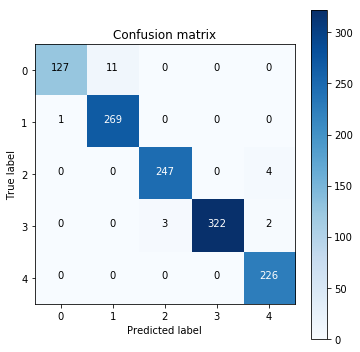

In [14]:
displayConfusionMatrix(y_test, y_pred,5)

=> Idem on a un score à plus de 98% !

## 2.5 Decision Tree

Classification avec un arbre de décision.

In [16]:
dtree = tree.DecisionTreeClassifier()
parameters = [{'criterion' : ['entropy', 'gini'], 'max_depth': [1, 2, 3, 4, 5],'max_features': [1,2,3]}]
dtree_grid, y_pred = evaluateClassifier(dtree,parameters, x_train, y_train, x_test, y_test)

Best params : {'criterion': 'entropy', 'max_depth': 5, 'max_features': 3}
Classification accuracy: 93.32 % 


Confusion matrix, without normalization


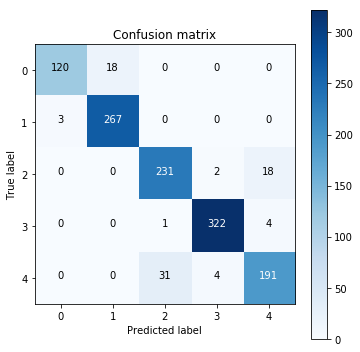

In [17]:
displayConfusionMatrix(y_test, y_pred,5)

=> Le score est moins élevé que les 2 précédents modèles même s'il reste plutôt bon.

## 2.6 KNN

Modèle KNN.

In [18]:
knn = neighbors.KNeighborsClassifier()
parameters = [{'n_neighbors': np.arange(1,50,1), 'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}]
knn_grid, y_pred = evaluateClassifier(knn,parameters, x_train, y_train, x_test, y_test  )

Best params : {'algorithm': 'brute', 'n_neighbors': 38}
Classification accuracy: 97.44 % 


Confusion matrix, without normalization


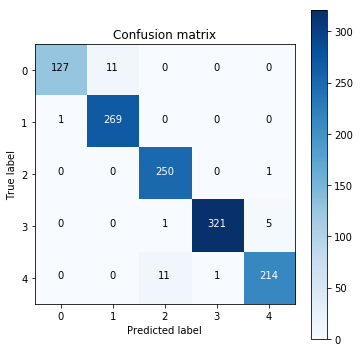

In [19]:
displayConfusionMatrix(y_test, y_pred,5)

=> Resultat toujours aussi encourageant au niveau du score de prédiction.

## 2.7 Random Forest

Testons maintenant un modèle ensembliste de type Forêt Aléatoire.

In [20]:
rfc = RandomForestClassifier(oob_score = True)
parameters = { 
    'n_estimators': [50, 100, 200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}
rfc_grid, y_pred = evaluateClassifier(rfc,parameters, x_train, y_train, x_test, y_test  )

Best params : {'max_features': 'auto', 'n_estimators': 100}
Classification accuracy: 98.68 % 


Confusion matrix, without normalization


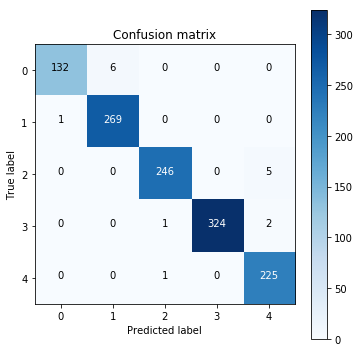

In [21]:
displayConfusionMatrix(y_test, y_pred,5)

=> Le score est très bon (98,68%).

## 2.8 Gradient Boosting

Le gradient boosting est très utilisé quand il s'agit d'utiliser les arbres de décision.

In [24]:
gb = ensemble.GradientBoostingClassifier()
parameters = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb_grid, y_pred = evaluateClassifier(gb,parameters, x_train, y_train, x_test, y_test  )

Best params : {'n_estimators': 100}
Classification accuracy: 98.68 % 


Confusion matrix, without normalization


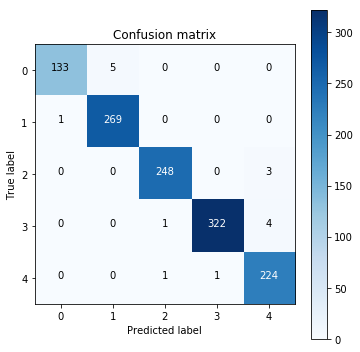

In [25]:
displayConfusionMatrix(y_test, y_pred,5)

=> Un très bon score aussi avec ce modèle.

## 2.9 XGBoost

Essayons maintenant un variante du Gradient Boosting. Nous essons l'Extreme Gradient Boosting qui est un algorithme Open Source.

In [22]:
xgb_model = xgb.XGBClassifier()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [6],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [5], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}
xgb_grid, y_pred = evaluateClassifier(xgb_model,parameters, x_train, y_train, x_test, y_test  )

Best params : {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 5, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1337, 'silent': 1, 'subsample': 0.8}
Classification accuracy: 96.53 % 


Confusion matrix, without normalization


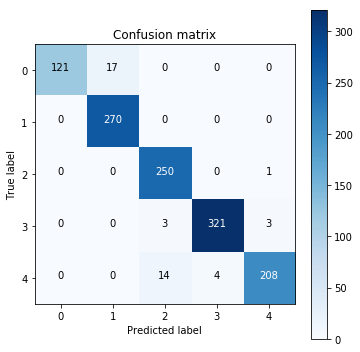

In [23]:
displayConfusionMatrix(y_test, y_pred,5)

=> Le score reste très correct (96%) mais moins bon que d'autres algorithmes précédents. Cependant on peut noter la rapidité d'execution de l'algorithme.

# 2.10 Bilan des évalutions de modèles

Affichons les scores de chacun des modèles testés

In [45]:
models = { 'Support Vector Machine' : svc_grid, 'Logistic Regression' : lr_grid, 'K-NN' : knn_grid, 
          'Decision Tree' : dtree_grid, 'Random Forest' : rfc_grid, 'Gradient Boosting' : gb_grid, 'XGBoost' : xgb_grid}
for k, v in models.items() :
    print("{:s} : best score = {:.3f}%".format(k,v.best_score_))

Support Vector Machine : best score = 0.981%
Logistic Regression : best score = 0.982%
K-NN : best score = 0.983%
Decision Tree : best score = 0.908%
Random Forest : best score = 0.986%
Gradient Boosting : best score = 0.988%
XGBoost : best score = 0.959%


Les 3 algorithmes donnant les meilleurs resultats : **gradient boosting, random forest et logistic regression.**

## 2.11 Agregation des meilleurs modèles

Voyons si on améliore le score en faisant une combinaison des 3 meilleurs algorithmes.

In [75]:
lr_best  = linear_model.LogisticRegression(**lr_grid.best_params_)
rf_best  = RandomForestClassifier(**rfc_grid.best_params_)
gb_best = ensemble.GradientBoostingClassifier(**gb_grid.best_params_)

In [72]:
votingC = ensemble.VotingClassifier(estimators=[('lr',lr_best),('gb',gb_best),('rf',rf_best)], voting='soft') 

In [73]:
votingC = votingC.fit(x_train,y_train)

In [74]:
y_pred = votingC.predict(x_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(y_test, y_pred)))

Precision: 98.84 % 


=> Nous obtenons un excellent score qui est le meilleur de tous nos algorithmes.

Nous ajoutons aussi ce modèle à notre ensemble.

In [103]:
models['Voting Classifier'] = votingC

# 3. Tests des prediction

## 3.1 Chargement du jeu de test

Pour mesure la stabilité de nos modèles, on va faire des prédictions sur le jeu de tests qui a été créé pendant la phase de clustering.
Pour rappel, nous avons séparé nos données en jeu de test et d'entrainement et appliqué le clustering uniquement sur le jeu d'entrainement. L'objectif était de ne pas biaiser l'étape classification.

In [77]:
test_orders = pd.read_csv('test_orders.csv')
test_orders['InvoiceDate']=pd.to_datetime(test_orders['InvoiceDate'])
test_orders.head()

,CustomerID,InvoiceNo,OrderPrice,OrderQuantity,OrderCanceled,OrderDiscount,OrderPromo,isUK,InvoiceDate
0,12347.0,537626,711.79,319,0,0,0,0,2010-12-07 14:57:00.000001024
1,12347.0,549222,636.25,483,0,0,0,0,2011-04-07 10:42:59.999999232
2,12347.0,556201,382.52,196,0,0,0,0,2011-06-09 13:01:00.000000256
3,12348.0,539318,652.80,1248,0,0,0,0,2010-12-16 19:09:00.000000000
4,12348.0,548955,327.00,268,0,0,0,0,2011-04-05 10:47:00.000000000


On charge notre algorithme de clustering.

In [78]:
from sklearn.externals import joblib
kmeans = joblib.load('kmeans_cluster.pkl') 

## 3.2 Regroupement données par client

On utilise la méthode précédente pour créer une table avec les données d'achat par client.

In [79]:
'''
Regroupement des données d'achats par client.
'''
def createDataStructureByCustomer(orders_d, dtmax) :
    temp = orders_d.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].agg(['count'])
    c_data=temp.rename(columns={'count': 'NbOrders'})
    c_data.reset_index(drop = False, inplace = True)

    temp = orders_d.groupby(by=['CustomerID','InvoiceNo'], as_index=False)['OrderPrice'].sum()
    temp = temp.groupby(by=['CustomerID'])['OrderPrice'].agg(['sum','mean','min','max'])
    temp=temp.rename(columns={'sum':'TotalSpent', 'mean':'AverageSpent','min':'MinSpent','max':'MaxSpent'})
    temp.reset_index(drop = False, inplace = True)
    c_data=pd.merge(c_data, temp, on='CustomerID', how='outer')

    temp = orders_d.groupby(by=['CustomerID'], as_index=False)['OrderQuantity'].agg(['sum'])
    temp=temp.rename(columns={'sum': 'TotalQuantity'})
    temp.reset_index(drop = False, inplace = True)
    c_data=pd.merge(c_data, temp, on='CustomerID', how='outer')

    temp = orders_d.groupby(by=['CustomerID'], as_index=False)['OrderCanceled'].agg(['sum'])
    temp=temp.rename(columns={'sum': 'NbCanceled'})
    temp.reset_index(drop = False, inplace = True)
    c_data=pd.merge(c_data, temp, on='CustomerID', how='outer')

    temp = orders_d.groupby(by=['CustomerID'], as_index=False)['OrderDiscount'].agg(['sum'])
    temp=temp.rename(columns={'sum': 'NbDiscount'})
    temp.reset_index(drop = False, inplace = True)
    c_data=pd.merge(c_data, temp, on='CustomerID', how='outer')

    temp = orders_d.groupby(by=['CustomerID'], as_index=False)['OrderPromo'].agg(['sum'])
    temp=temp.rename(columns={'sum': 'NbPromo'})
    temp.reset_index(drop = False, inplace = True)
    c_data=pd.merge(c_data, temp, on='CustomerID', how='outer')

    temp = orders_d.groupby(by=['CustomerID'], as_index=False).agg({'isUK': lambda x: 1 if (x.all()>0) else 0})
    c_data=pd.merge(c_data, temp, on='CustomerID', how='outer')

    #dtmax = orders_d.InvoiceDate.max()
    now = dt.datetime(dtmax.year, dtmax.month, dtmax.day) + dt.timedelta(days=1)
    temp = orders_d.groupby('CustomerID').agg({'InvoiceDate': lambda x: (now - x.max()).days})
    temp=temp.rename(columns={'InvoiceDate': 'LastPurchase'})
    temp.reset_index(drop = False, inplace = True)
    c_data=pd.merge(c_data, temp, on='CustomerID', how='outer')
    return c_data

La date max de notre base : 9/12/2011.

In [82]:
max_date = dt.datetime(2011, 12, 9, 0, 0)

On créé la structure.

In [83]:
test_customers_data = createDataStructureByCustomer(test_orders, max_date)

In [84]:
test_customers_data.head()

,CustomerID,NbOrders,TotalSpent,AverageSpent,MinSpent,MaxSpent,TotalQuantity,NbCanceled,NbDiscount,NbPromo,isUK,LastPurchase
0,12347.0,3,1730.56,576.853333,382.52,711.79,998,0,0,0,0,183
1,12348.0,2,979.80,489.900000,327.00,652.80,1516,0,0,0,0,248
2,12352.0,1,104.35,104.350000,104.35,104.35,25,0,0,0,0,283
3,12359.0,1,1109.32,1109.320000,1109.32,1109.32,356,0,0,0,0,189
4,12362.0,2,416.20,208.100000,-17.90,434.10,218,3,0,0,0,112


## 3.3 Prédiction des clusters

Notre table est maintenant construite. Il faut maintenant faire un traitement sur les données pour qu'elles correspondent aux quantiles (comme fait dans la phase de segmentation).

In [98]:
x_test_customers = createQuantileMatrix(test_customers_data.drop(['CustomerID'], axis=1))

On prédit les clusters avec notre algorithme kmeans. Ce sera notre target variable et celle qui permettra de vérifier la qualité des classifications.

Les clients seront affectées au cluster ayant le centroide le plus proche (avec la méthode predict).

In [99]:
y_test_customers_labels = kmeans.predict(x_test_customers)

Regardons la répartitions des clients.

In [100]:
pd.DataFrame(pd.Series(y_test_customers_labels).value_counts(), columns = ['NbCustomers']).sort_values(by='NbCustomers',ascending=False).T

,2,3,4,0,1
NbCustomers,586,568,469,264,246


=> La répartition parait cohérente.

## 3.4 Stabilité des modèles de classification

In [104]:
for m in models :
    print(m)

Support Vector Machine
Logistic Regression
K-NN
Decision Tree
Random Forest
Gradient Boosting
XGBoost
Voting Classifier


In [105]:
for m_label, model in models.items() :
    y_predicted= model.predict(x_test_customers)
    score = 100*metrics.accuracy_score(y_test_customers_labels, y_predicted)
    print("{:s} : Precision = {:.3f}%".format(m_label,score))

Support Vector Machine : Precision = 98.547%
Logistic Regression : Precision = 98.875%
K-NN : Precision = 97.328%
Decision Tree : Precision = 87.248%
Random Forest : Precision = 98.078%
Gradient Boosting : Precision = 98.218%
XGBoost : Precision = 95.781%
Voting Classifier : Precision = 98.172%


Les scores obtenus sont très bons. Nous obtenons le meilleur score avec la regression logistique mais le SVM, le Gradient Boosting, le Random Forest et le Voting Classifier nous donne tous un score supérieur à 98%.